In [13]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [14]:
# CIFAR-10 mean and standard deviation
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD),
])

# Load datasets
raw_train_dataset = datasets.CIFAR10(root='data/CIFAR10', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='data/CIFAR10', train=False, download=True, transform=test_transform)
train_dataset, val_dataset = torch.utils.data.random_split(raw_train_dataset, [0.9, 0.1])

print(f"{len(train_dataset)} samples in CIFAR10 train dataset")
print(f"{len(val_dataset)} samples in CIFAR10 validation dataset")
print(f"{len(test_dataset)} samples in CIFAR10 test dataset")

45000 samples in CIFAR10 train dataset
5000 samples in CIFAR10 validation dataset
10000 samples in CIFAR10 test dataset


In [15]:
BATCH_SIZE = 64
NUM_OF_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

print(f"{len(train_loader)} batches in train dataset")
print(f"{len(val_loader)} batches in validation dataset")
print(f"{len(test_dataset)} batches in test dataset")

704 batches in train dataset
79 batches in validation dataset
10000 batches in test dataset


In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.relu = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                               stride=1) if in_channels != out_channels else None

    def forward(self, x):
        out = self.block(x)
        if self.conv3 is not None:
            x = self.conv3(x)
        out += x
        out = self.relu(out)

        return out

In [17]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes=10, num_blocks=6):
        super().__init__()

        self.initial_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.hidden_blocks = nn.Sequential(
            ResidualBlock(32, 128),
            ResidualBlock(128, 64),
            nn.MaxPool2d(2),
            ResidualBlock(64, 32),
            nn.MaxPool2d(2),
        )

        self.flatten = nn.Flatten(start_dim=1)

        # Classification head
        self.classification_head = nn.Sequential(
            # num_channels, height, width
            nn.Linear(32 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x, verbose=False):
        if verbose:
            print(f"{x.shape=}")
        x = self.initial_block(x)
        if verbose:
            print(f"{x.shape=}")
        x = self.hidden_blocks(x)
        if verbose:
            print(f"{x.shape=}")
        x = self.flatten(x)
        if verbose:
            print(f"{x.shape=}")
        x = self.classification_head(x)
        if verbose:
            print(f"{x.shape=}")
        return x

In [18]:
# Test model's functionality with dummy data point
model = ResNetModel(num_classes=10)

dummy_dp = torch.randn(10, 3, 32, 32)
dummy_output = model.forward(dummy_dp)

print(f"Dummy output logits shape: {dummy_output.shape}")

Dummy output logits shape: torch.Size([10, 10])


In [19]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()

buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024 / 1024

print(f"Parameter size in MB: {param_size / 1024 / 1024}")
print(f"Buffer size in MB: {buffer_size / 1024 / 1024}")
print(f"Overall model size in MB: {size_all_mb}")

Parameter size in MB: 5.861244201660156
Buffer size in MB: 0.00371551513671875
Overall model size in MB: 5.864959716796875


In [20]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
from tqdm import tqdm


def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    correct = 0
    total_predictions = 0

    pbar = tqdm(train_loader, desc="Training")
    for inputs, targets in pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted_class = outputs.max(1)
        total_predictions += targets.size(0)
        correct += predicted_class.eq(targets).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'accuracy': 100.0 * correct / total_predictions
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct / total_predictions

    return epoch_loss, epoch_accuracy

In [22]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='Validating'):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted_class = outputs.max(1)
            total_predictions += targets.size(0)
            correct += predicted_class.eq(targets).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = 100.0 * correct / total_predictions

    return epoch_loss, epoch_accuracy

In [23]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total_predictions = 0
    class_correct = [0] * 10
    class_total_predictions = [0] * 10

    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing'):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            _, predicted_class = outputs.max(1)

            total_predictions += targets.size(0)
            correct += predicted_class.eq(targets).sum().item()

            # Per-class accuracy
            for i in range(targets.size(0)):
                target = targets[i]
                class_correct[target] += (predicted_class[i] == target)
                class_total_predictions[target] += 1

    overall_acc = 100.0 * correct / total_predictions
    print(f"Overall accuracy: {overall_acc:.2f}%")
    print(f"Per class accuracy:")
    for i in range(10):
        acc = 100.0 * class_correct[i] / class_total_predictions[i]
        print(f"{classes[i]:>10s}: {acc:.2f}%")

    return overall_acc

In [24]:
import matplotlib.pyplot as plt

NUM_EPOCHS = 100
LEARNING_RATE = 0.001

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

stats = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}

best_val_acc = 0.0

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    stats['train_loss'].append(train_loss)
    stats['train_acc'].append(train_acc)
    stats['val_loss'].append(val_loss)
    stats['val_acc'].append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.2f}%")
        print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet_cifar10.pth")
        # print(f"Model saved with best validation accuracy: {best_val_acc:.2f}%")

Starting training...


Validating: 100%|██████████| 79/79 [00:05<00:00, 15.09it/s]


Epoch 5/100
Train loss: 1.2692, Train accuracy: 54.79%
Validation loss: 1.1522, Validation accuracy: 59.26%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.75it/s]


Epoch 10/100
Train loss: 1.0696, Train accuracy: 62.29%
Validation loss: 1.0139, Validation accuracy: 64.06%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.69it/s]


Epoch 15/100
Train loss: 0.9763, Train accuracy: 65.94%
Validation loss: 0.9589, Validation accuracy: 65.92%


Validating: 100%|██████████| 79/79 [00:05<00:00, 14.00it/s]


Epoch 20/100
Train loss: 0.9181, Train accuracy: 67.91%
Validation loss: 0.8771, Validation accuracy: 68.62%


Validating: 100%|██████████| 79/79 [00:06<00:00, 12.47it/s]


Epoch 25/100
Train loss: 0.8656, Train accuracy: 70.19%
Validation loss: 0.8130, Validation accuracy: 71.40%


Validating: 100%|██████████| 79/79 [00:06<00:00, 13.01it/s]


Epoch 30/100
Train loss: 0.8332, Train accuracy: 71.29%
Validation loss: 0.7758, Validation accuracy: 72.20%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.52it/s]


Epoch 35/100
Train loss: 0.8043, Train accuracy: 72.38%
Validation loss: 0.7600, Validation accuracy: 73.80%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.36it/s]


Epoch 40/100
Train loss: 0.7756, Train accuracy: 73.42%
Validation loss: 0.7574, Validation accuracy: 74.32%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.66it/s]


Epoch 45/100
Train loss: 0.7489, Train accuracy: 74.30%
Validation loss: 0.7353, Validation accuracy: 73.86%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.33it/s]


Epoch 50/100
Train loss: 0.7389, Train accuracy: 74.92%
Validation loss: 0.6948, Validation accuracy: 75.94%


Validating: 100%|██████████| 79/79 [00:06<00:00, 12.97it/s]


Epoch 55/100
Train loss: 0.7175, Train accuracy: 75.96%
Validation loss: 0.7235, Validation accuracy: 75.64%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.48it/s]


Epoch 60/100
Train loss: 0.7079, Train accuracy: 75.71%
Validation loss: 0.6931, Validation accuracy: 76.88%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.68it/s]


Epoch 65/100
Train loss: 0.6923, Train accuracy: 76.54%
Validation loss: 0.7096, Validation accuracy: 75.96%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.71it/s]


Epoch 70/100
Train loss: 0.6840, Train accuracy: 76.65%
Validation loss: 0.6703, Validation accuracy: 76.98%


Validating: 100%|██████████| 79/79 [00:06<00:00, 13.14it/s]


Epoch 75/100
Train loss: 0.6692, Train accuracy: 77.05%
Validation loss: 0.6404, Validation accuracy: 77.08%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.48it/s]


Epoch 80/100
Train loss: 0.6608, Train accuracy: 77.41%
Validation loss: 0.6509, Validation accuracy: 77.60%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.61it/s]


Epoch 85/100
Train loss: 0.6588, Train accuracy: 77.62%
Validation loss: 0.6422, Validation accuracy: 77.30%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.59it/s]


Epoch 90/100
Train loss: 0.6447, Train accuracy: 78.14%
Validation loss: 0.6564, Validation accuracy: 77.66%


Validating: 100%|██████████| 79/79 [00:05<00:00, 13.36it/s]


Epoch 95/100
Train loss: 0.6345, Train accuracy: 78.63%
Validation loss: 0.6137, Validation accuracy: 78.22%


Validating: 100%|██████████| 79/79 [00:06<00:00, 13.09it/s]

Epoch 100/100
Train loss: 0.6284, Train accuracy: 78.77%
Validation loss: 0.6318, Validation accuracy: 78.06%


Loading best model for testing...
Best validation accuracy: 79.00%


Testing: 100%|██████████| 157/157 [00:05<00:00, 26.89it/s]


Overall accuracy: 81.21%
Per class accuracy:
     plane: 84.10%
       car: 89.20%
      bird: 74.70%
       cat: 65.00%
      deer: 82.00%
       dog: 71.90%
      frog: 88.00%
     horse: 78.60%
      ship: 86.60%
     truck: 92.00%

Training history plot saved as 'training_history.png'


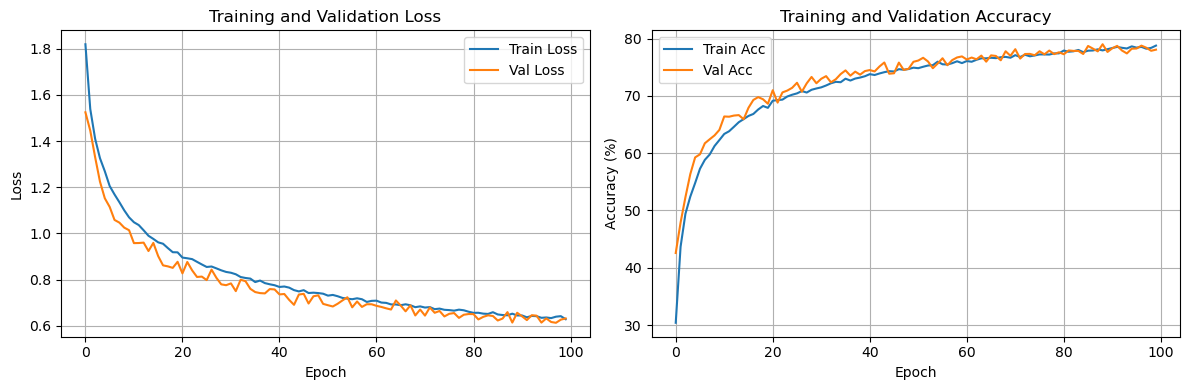

In [25]:
print('=' * 70)
print(f"Loading best model for testing...")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
model.load_state_dict(torch.load('best_resnet_cifar10.pth'))

test_acc = test(model, test_loader)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(stats['train_loss'], label='Train Loss')
plt.plot(stats['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(stats['train_acc'], label='Train Acc')
plt.plot(stats['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
print("\nTraining history plot saved as 'training_history.png'")
